### 0. Setup & Install Dependencies

In [ ]:
#Install Dependencies
!pip install pandas numpy scikit-learn nltk matplotlib seaborn

In [92]:
#pull from get
!git fetch origin
!git reset --hard origin/main

From https://github.com/Sorrel-Alvason/cs-ticket-categorizer
   671b162..b9213e7  main       -> origin/main


HEAD is now at b9213e7 Update README.md


In [93]:
#push to git
!git status
!git add 01_data_preprocessing.ipynb
!git commit -m "Edited Data Preprocessing Notebook"
!git push origin main

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


Everything up-to-date


### 1. Introduction & Notebook Objectives

### 2. Load the Dataset

#### Overview
In this Section, we will: 
    Load the dataset from 'dataset-tickets-milti-lang-4-20k.csv'
    Display the first few rows to understand its structure. 
    Filter out the necessary columns ('subject', 'body', 'queue', 'priority')
    check for missing values and basic statistics. 

#### Dataset Description
The dataset consists of customer service tickets with the following columns:
- **`subject`**: The subject line of the ticket (short summary).
- **`body`**: The detailed content of the ticket.
- **`queue`**: The category or type of issue the ticket belongs to.
- **`priority`**: The urgency level of the ticket.

These will be the key inputs (**features**) and outputs (**labels**) for our machine learning model.

In [72]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/dataset-tickets-multi-lang-4-20k.csv")

# Display basic info
print("Dataset Shape:", df.shape)
print("Column Names:", df.columns.tolist())

# Select only relevant columns
df = df[['subject', 'body', 'queue', 'priority']]

# Show first few rows
df.head()

Dataset Shape: (20000, 15)
Column Names: ['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']


,subject,body,queue,priority
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,General Inquiry,low
1,Customer Support Inquiry,Seeking information on digital strategies that...,Customer Service,medium
2,Data Analytics for Investment,I am contacting you to request information on ...,Customer Service,medium
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Customer Service,high
4,Security,"Dear Customer Support, I am reaching out to in...",Customer Service,medium


### 3. Explore & Understand Data

#### Inspect Dataset

Before proceeding with preprocessing, we need to understand:
- The total number of entries (**shape of the dataset**).
- The available columns (**column names**).
- Sample rows (**`df.head()`**).
- How many missing values are present (**`df.isnull().sum()`**).

This helps us determine if any cleaning is necessary before feature engineering.


In [73]:
# Check for missing values
df.isnull().sum()

# Basic statistics for text length (subject and body)
df['subject_length'] = df['subject'].apply(lambda x: len(str(x)))
df['body_length'] = df['body'].apply(lambda x: len(str(x)))

# Compute mean and standard deviation dynamically
subject_mean = df["subject_length"].mean()
subject_std = df["subject_length"].std()

body_mean = df["body_length"].mean()
body_std = df["body_length"].std()

#show table
df[['subject_length', 'body_length']].describe()



,subject_length,body_length
count,20000.000000,20000.000000
mean,41.813750,394.438400
std,21.170191,248.260435
min,3.000000,3.000000
25%,31.000000,198.000000
50%,41.000000,357.000000
75%,53.000000,555.000000
max,412.000000,2259.000000


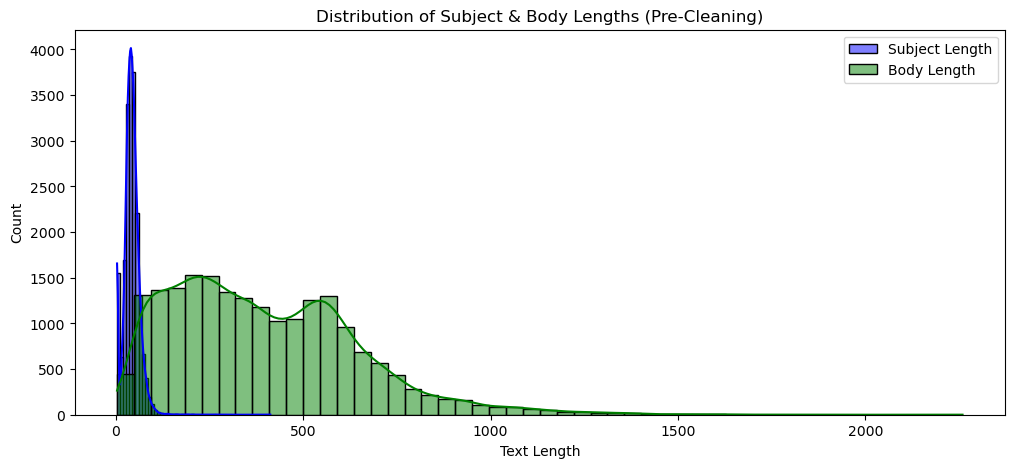

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of subject and body lengths
plt.figure(figsize=(12,5))

sns.histplot(df['subject_length'], bins=50, kde=True, color='blue', label="Subject Length")
sns.histplot(df['body_length'], bins=50, kde=True, color='green', label="Body Length")

plt.xlabel("Text Length")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Subject & Body Lengths (Pre-Cleaning)")
plt.show()


Based on these results, we should focus on
removing tickets that are too short (<3 char)
removing tickets that are too long (2000+ char)
we should remove noise and focus on relevant info in the text

### 4. Clean and Preprocess Text Data

#### Handling Missing or Very Short Ticket Texts
Remove empty or very short subject/body texts ( < 5 characters).

Replace missing values with a placeholder ("no_subject", "No_body")


In [83]:
#create an in process dataframe to compare pre-clean statistics to post-clean statistics
df_processing = df

# Remove rows where 'subject' or 'body' are too short to be useful
df_processing = df_processing[(df_processing['subject_length'] >= 5) & (df_processing['body_length'] >= 5)]

#### Handling Very Long Ticket Texts
Remove empty or very long subject/body texts ( > 4 Standard Deviations from the Mean).

In [84]:
# Calculate upper bounds using 4 standard deviations from the mean
subject_upper_bound = subject_mean + (4 * subject_std)
body_upper_bound = body_mean + (4 * body_std)

# Remove extreme outliers
df_processing = df_processing[(df_processing["subject_length"] <= subject_upper_bound) & (df_processing["body_length"] <= body_upper_bound)]

#### Convert Text to Lowercase
We should treat text processing as case-insensitive. \
For example **"Email Issue"** and "email issue" should be treated the same. 

In [85]:
df_processing['subject'] = df['subject'].str.lower()
df_processing['body'] = df['body'].str.lower()

#### Remove Special Characters, Punctuation, and Numbers
These three text elements will not add much to the model and should be removed. 

In [86]:
import re

def clean_text(text):
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)   # Remove numbers
    return text

df_processing['subject'] = df_processing['subject'].apply(clean_text)
df_processing['body'] = df_processing['body'].apply(clean_text)

#### Remove Common Customer Service Phrases
getting rid of irrelevant phrases such as greetings and signatures. 

In [87]:
#dictionary of common phrases
common_phrases = ["hello", 
                  "hi there", 
                  "dear support team", 
                  "best regards", 
                  "thank you"]

In [88]:
#Remove common phrases
def remove_common_phrases(text):
    for phrase in common_phrases:
        text = text.replace(phrase, "")
    return text.strip()

df_processing['body'] = df_processing['body'].apply(remove_common_phrases)

#### Check the Distribution of Subject & Body Lengths (post-cleaning)
We should check if the distribution looks more reasonable. 

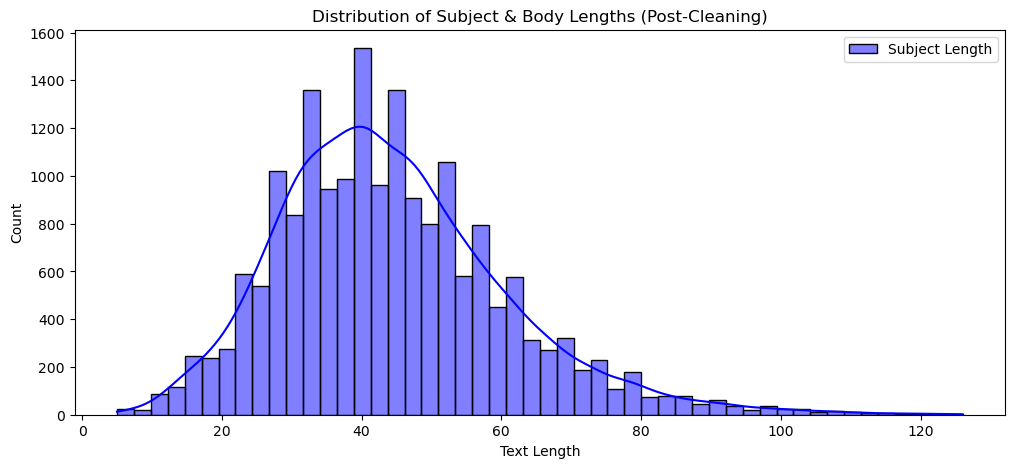

In [89]:
plt.figure(figsize=(12,5))
sns.histplot(df_processing['subject'].apply(len), bins=50, kde=True, color='blue', label="Subject Length")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Subject & Body Lengths (Post-Cleaning)")
plt.show()

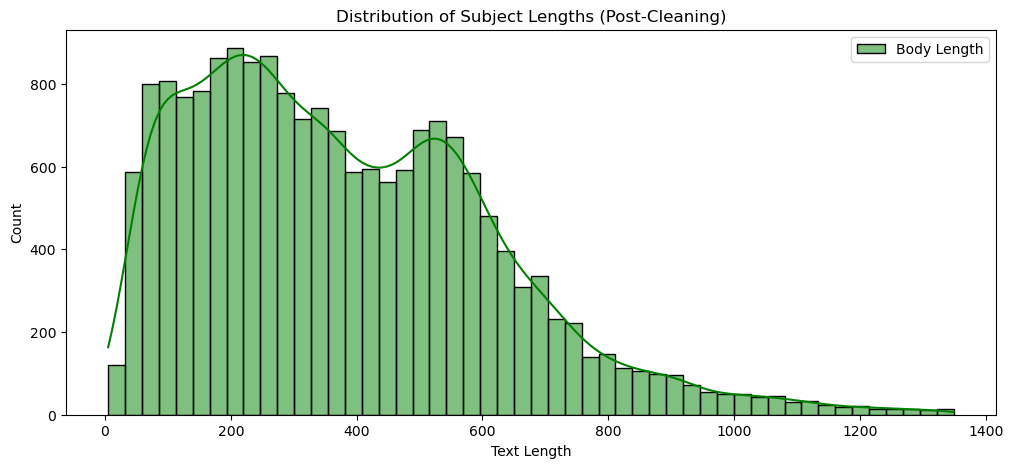

In [69]:
# Plot histogram of subject and body lengths
plt.figure(figsize=(12,5))
sns.histplot(df_processing['body'].apply(len), bins=50, kde=True, color='green', label="Body Length")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Subject Lengths (Post-Cleaning)")
plt.show()

In [90]:
from IPython.display import display

# compute statistics
raw_stats = df[["subject_length", "body_length"]].describe()
processed_stats = df_processing[["subject_length", "body_length"]].describe()

#compute the difference (delta) between raw and processed stats
delta_stats = processed_stats - raw_stats

# Concatenate side by side
comparison_stats = pd.concat([raw_stats, processed_stats, delta_stats], axis=1, keys=["Raw Data", "Processed Data", "Change in Stats"])

# Display side-by-side tables
display(comparison_stats)

Raw Data               Processed Data                \
      subject_length   body_length subject_length   body_length   
count   20000.000000  20000.000000   18448.000000  18448.000000   
mean       41.813750    394.438400      44.400423    389.134432   
std        21.170191    248.260435      16.481643    245.669878   
min         3.000000      3.000000       5.000000      5.000000   
25%        31.000000    198.000000      33.000000    194.000000   
50%        41.000000    357.000000      42.000000    350.000000   
75%        53.000000    555.000000      53.000000    551.000000   
max       412.000000   2259.000000     126.000000   1385.000000   

      Change in Stats               
       subject_length  body_length  
count    -1552.000000 -1552.000000  
mean         2.586673    -5.303968  
std         -4.688548    -2.590557  
min          2.000000     2.000000  
25%          2.000000    -4.000000  
50%          1.000000    -7.000000  
75%          0.000000    -4.000000  
max       -286.000000  -874.000000

### Tokenization

### Stemming/lemmatization

### Saving the Cleaned Dataset